# Setup

In [21]:
# Define Parameters
batch_size = 128
epochs = 100
task = 'Damage_Severity_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
# Damage Severity
train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_train_final.tsv'
test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_test_final.tsv'
dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_dev_final.tsv'

train_label = pd.read_table(train_path)
test_label = pd.read_table(test_path)
dev_label = pd.read_table(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(28319, 4)
(3865, 4)
(2712, 4)


In [4]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('/work/u9562361/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.resize((224, 224))
            img = img.convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [5]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

 95%|█████████▍| 26889/28319 [13:22<00:49, 28.86it/s]

Error opening image: /work/u9562361/crisis_vision_benchmarks/data/multimodal-deep-learning-disaster-response-mouzannar/multimodal/damaged_infrastructure/images/wreckedcar_2017-02-23_21-15-25.jpg - image file is truncated (0 bytes not processed)


100%|██████████| 28319/28319 [14:00<00:00, 33.70it/s]


torch.Size([3, 224, 224])
(28318, 3, 224, 224)


100%|██████████| 28318/28318 [00:00<00:00, 494977.48it/s]


(28318,)


100%|██████████| 3865/3865 [02:03<00:00, 31.28it/s]


torch.Size([3, 224, 224])
(3865, 3, 224, 224)


100%|██████████| 3865/3865 [00:00<00:00, 464711.18it/s]


(3865,)


100%|██████████| 2712/2712 [01:27<00:00, 31.03it/s]


torch.Size([3, 224, 224])
(2712, 3, 224, 224)


100%|██████████| 2712/2712 [00:00<00:00, 479611.77it/s]

(2712,)


In [6]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_pretrained

In [10]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/u9562361/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Train

In [11]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [12]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [13]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.6145 - accuracy: 75.91% - val_loss: 0.6013 - val_accuracy: 74.72% - time: 95.90s
Epoch 2/100 - loss: 0.4391 - accuracy: 82.67% - val_loss: 0.5955 - val_accuracy: 74.90% - time: 95.81s
Epoch 3/100 - loss: 0.3297 - accuracy: 87.28% - val_loss: 0.6285 - val_accuracy: 74.70% - time: 95.75s
Epoch 4/100 - loss: 0.2421 - accuracy: 91.54% - val_loss: 0.6924 - val_accuracy: 74.18% - time: 95.89s
Epoch 5/100 - loss: 0.1775 - accuracy: 94.25% - val_loss: 0.7635 - val_accuracy: 73.74% - time: 95.85s
Epoch 6/100 - loss: 0.1362 - accuracy: 95.68% - val_loss: 0.8138 - val_accuracy: 73.87% - time: 95.81s
Epoch 7/100 - loss: 0.1128 - accuracy: 96.41% - val_loss: 0.8635 - val_accuracy: 72.70% - time: 95.84s
Epoch 8/100 - loss: 0.0970 - accuracy: 96.82% - val_loss: 0.8828 - val_accuracy: 73.09% - time: 95.97s
Epoch 9/100 - loss: 0.0880 - accuracy: 97.04% - val_loss: 0.9156 - val_accuracy: 73.20% - time: 95.99s
Epoch 10/100 - loss: 0.0795 - accuracy: 97.23% - val_loss: 0.9129 - val_a

Epoch 80/100 - loss: 0.0303 - accuracy: 98.79% - val_loss: 1.0100 - val_accuracy: 73.20% - time: 96.13s
Epoch 81/100 - loss: 0.0318 - accuracy: 98.74% - val_loss: 1.0112 - val_accuracy: 73.27% - time: 96.14s
Epoch 82/100 - loss: 0.0306 - accuracy: 98.81% - val_loss: 1.0096 - val_accuracy: 73.58% - time: 96.05s
Epoch 83/100 - loss: 0.0306 - accuracy: 98.81% - val_loss: 1.0220 - val_accuracy: 73.64% - time: 96.19s
Epoch 84/100 - loss: 0.0302 - accuracy: 98.86% - val_loss: 1.0058 - val_accuracy: 73.30% - time: 96.25s
Epoch 85/100 - loss: 0.0309 - accuracy: 98.83% - val_loss: 1.0134 - val_accuracy: 73.61% - time: 96.23s
Epoch 86/100 - loss: 0.0314 - accuracy: 98.80% - val_loss: 1.0139 - val_accuracy: 73.22% - time: 96.14s
Epoch 87/100 - loss: 0.0298 - accuracy: 98.80% - val_loss: 1.0067 - val_accuracy: 73.45% - time: 96.15s
Epoch 88/100 - loss: 0.0311 - accuracy: 98.84% - val_loss: 1.0072 - val_accuracy: 73.61% - time: 96.08s
Epoch 89/100 - loss: 0.0311 - accuracy: 98.82% - val_loss: 1.013

In [14]:
print(task + '_ResNet50_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet50_pretrained Performance:
Accuracy : 75.55%
F1-Score : 74.11%
Damage_Severity_Classification_ResNet50_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2135
           1       0.41      0.46      0.43       629
           2       0.76      0.65      0.70      1101

    accuracy                           0.73      3865
   macro avg       0.66      0.65      0.66      3865
weighted avg       0.74      0.73      0.73      3865



## Visualize Results & Confusion Matrix

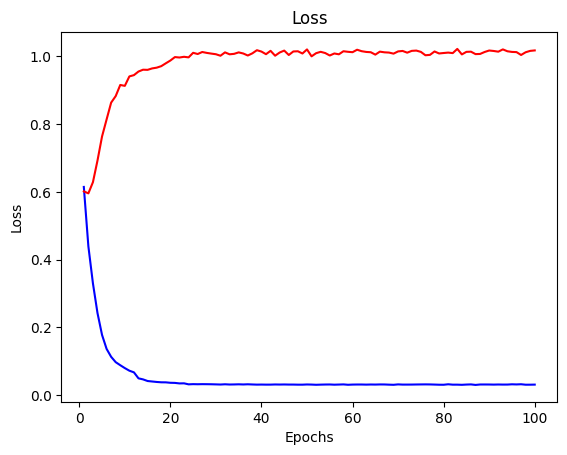

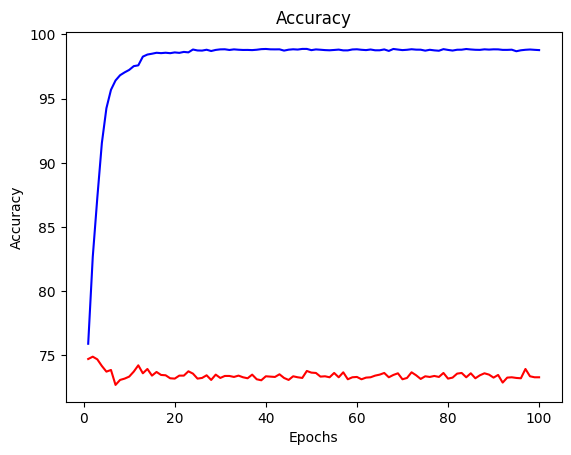

In [15]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet50_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


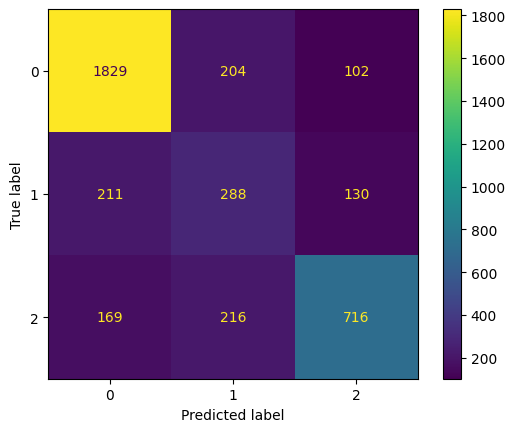

In [16]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet50_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_pretrained

In [17]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /home/u9562361/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

## Train

In [18]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [19]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [20]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.9227 - accuracy: 60.62% - val_loss: 0.8960 - val_accuracy: 64.92% - time: 81.08s
Epoch 2/100 - loss: 0.7013 - accuracy: 73.44% - val_loss: 0.7527 - val_accuracy: 68.90% - time: 80.87s
Epoch 3/100 - loss: 0.6123 - accuracy: 75.85% - val_loss: 0.6872 - val_accuracy: 70.06% - time: 80.96s
Epoch 4/100 - loss: 0.5641 - accuracy: 77.21% - val_loss: 0.6527 - val_accuracy: 71.57% - time: 80.95s
Epoch 5/100 - loss: 0.5303 - accuracy: 78.44% - val_loss: 0.6349 - val_accuracy: 72.55% - time: 80.87s
Epoch 6/100 - loss: 0.5046 - accuracy: 79.70% - val_loss: 0.6198 - val_accuracy: 73.35% - time: 80.95s
Epoch 7/100 - loss: 0.4903 - accuracy: 80.32% - val_loss: 0.6122 - val_accuracy: 73.92% - time: 80.88s
Epoch 8/100 - loss: 0.4695 - accuracy: 80.99% - val_loss: 0.6011 - val_accuracy: 74.31% - time: 80.79s
Epoch 9/100 - loss: 0.4553 - accuracy: 81.53% - val_loss: 0.5955 - val_accuracy: 74.44% - time: 81.02s
Epoch 10/100 - loss: 0.4400 - accuracy: 82.12% - val_loss: 0.5909 - val_a

Epoch 80/100 - loss: 0.2573 - accuracy: 90.07% - val_loss: 0.6482 - val_accuracy: 75.08% - time: 80.92s
Epoch 81/100 - loss: 0.2615 - accuracy: 89.70% - val_loss: 0.6501 - val_accuracy: 75.27% - time: 80.91s
Epoch 82/100 - loss: 0.2558 - accuracy: 90.14% - val_loss: 0.6515 - val_accuracy: 75.29% - time: 80.86s
Epoch 83/100 - loss: 0.2597 - accuracy: 89.80% - val_loss: 0.6497 - val_accuracy: 75.16% - time: 80.98s
Epoch 84/100 - loss: 0.2588 - accuracy: 90.05% - val_loss: 0.6509 - val_accuracy: 75.24% - time: 80.75s
Epoch 85/100 - loss: 0.2599 - accuracy: 89.95% - val_loss: 0.6601 - val_accuracy: 74.90% - time: 81.03s
Epoch 86/100 - loss: 0.2595 - accuracy: 89.85% - val_loss: 0.6519 - val_accuracy: 75.34% - time: 80.92s
Epoch 87/100 - loss: 0.2562 - accuracy: 89.99% - val_loss: 0.6544 - val_accuracy: 75.32% - time: 80.77s
Epoch 88/100 - loss: 0.2560 - accuracy: 90.11% - val_loss: 0.6539 - val_accuracy: 75.08% - time: 80.85s
Epoch 89/100 - loss: 0.2581 - accuracy: 89.92% - val_loss: 0.651

In [21]:
print(task + '_EfficientNetb1_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_EfficientNetb1_pretrained Performance:
Accuracy : 76.41%
F1-Score : 75.31%
Damage_Severity_Classification_EfficientNetb1_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2135
           1       0.45      0.42      0.44       629
           2       0.73      0.73      0.73      1101

    accuracy                           0.75      3865
   macro avg       0.68      0.67      0.67      3865
weighted avg       0.75      0.75      0.75      3865



## Visualize Results & Confusion Matrix

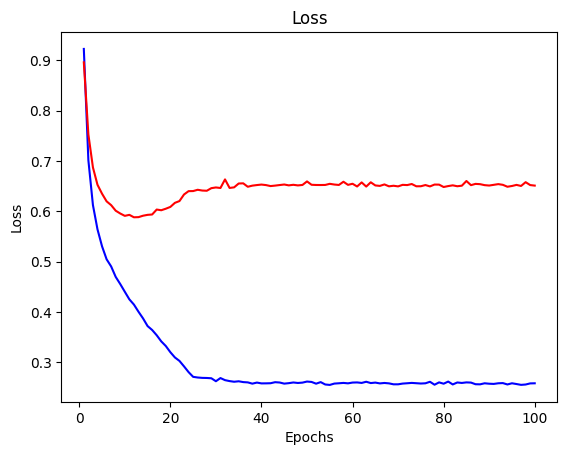

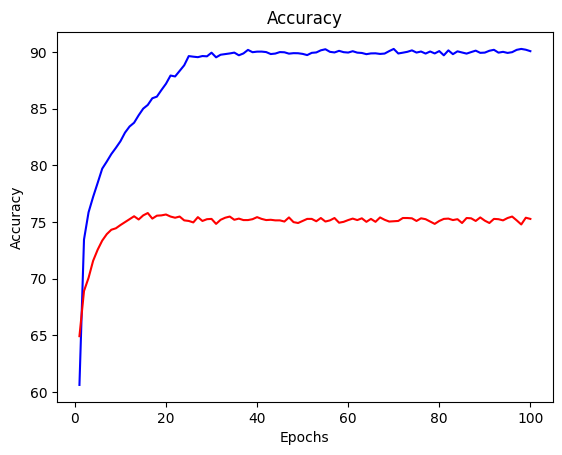

In [22]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_EfficientNetb1_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


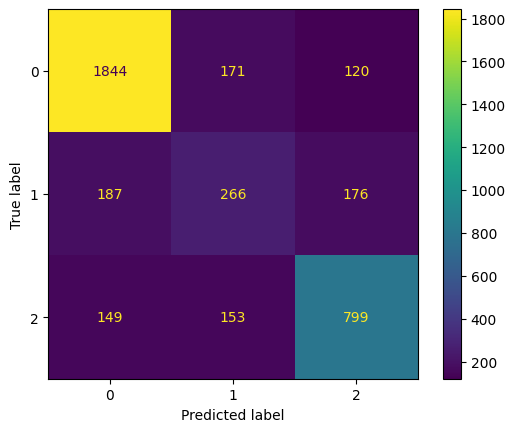

In [23]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_EfficientNetb1_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_pretrained

In [24]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [25]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [26]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [27]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.6644 - accuracy: 72.37% - val_loss: 0.6306 - val_accuracy: 72.55% - time: 138.41s
Epoch 2/100 - loss: 0.5201 - accuracy: 79.06% - val_loss: 0.6012 - val_accuracy: 74.62% - time: 138.59s
Epoch 3/100 - loss: 0.4595 - accuracy: 81.63% - val_loss: 0.5873 - val_accuracy: 75.01% - time: 138.54s
Epoch 4/100 - loss: 0.4067 - accuracy: 83.58% - val_loss: 0.5941 - val_accuracy: 75.01% - time: 138.58s
Epoch 5/100 - loss: 0.3547 - accuracy: 86.10% - val_loss: 0.6085 - val_accuracy: 75.65% - time: 138.55s
Epoch 6/100 - loss: 0.3020 - accuracy: 88.23% - val_loss: 0.6322 - val_accuracy: 75.14% - time: 138.49s
Epoch 7/100 - loss: 0.2556 - accuracy: 90.15% - val_loss: 0.6589 - val_accuracy: 75.76% - time: 138.57s
Epoch 8/100 - loss: 0.2162 - accuracy: 91.80% - val_loss: 0.7123 - val_accuracy: 75.42% - time: 138.54s
Epoch 9/100 - loss: 0.1753 - accuracy: 93.48% - val_loss: 0.7750 - val_accuracy: 75.19% - time: 138.56s
Epoch 10/100 - loss: 0.1559 - accuracy: 94.39% - val_loss: 0.804

Epoch 80/100 - loss: 0.0622 - accuracy: 97.41% - val_loss: 1.1816 - val_accuracy: 75.27% - time: 138.57s
Epoch 81/100 - loss: 0.0630 - accuracy: 97.43% - val_loss: 1.1817 - val_accuracy: 75.29% - time: 138.60s
Epoch 82/100 - loss: 0.0636 - accuracy: 97.46% - val_loss: 1.1815 - val_accuracy: 75.27% - time: 138.60s
Epoch 83/100 - loss: 0.0639 - accuracy: 97.34% - val_loss: 1.1811 - val_accuracy: 75.27% - time: 138.63s
Epoch 84/100 - loss: 0.0644 - accuracy: 97.46% - val_loss: 1.1815 - val_accuracy: 75.27% - time: 138.60s
Epoch 85/100 - loss: 0.0619 - accuracy: 97.43% - val_loss: 1.1818 - val_accuracy: 75.27% - time: 138.65s
Epoch 86/100 - loss: 0.0646 - accuracy: 97.35% - val_loss: 1.1817 - val_accuracy: 75.29% - time: 138.71s
Epoch 87/100 - loss: 0.0635 - accuracy: 97.42% - val_loss: 1.1825 - val_accuracy: 75.29% - time: 138.60s
Epoch 88/100 - loss: 0.0632 - accuracy: 97.45% - val_loss: 1.1828 - val_accuracy: 75.29% - time: 138.82s
Epoch 89/100 - loss: 0.0613 - accuracy: 97.59% - val_lo

In [28]:
print(task + '_VGG16_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_VGG16_pretrained Performance:
Accuracy : 76.39%
F1-Score : 75.04%
Damage_Severity_Classification_VGG16_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      2135
           1       0.46      0.34      0.39       629
           2       0.71      0.76      0.73      1101

    accuracy                           0.75      3865
   macro avg       0.67      0.66      0.66      3865
weighted avg       0.74      0.75      0.74      3865



## Visualize Results & Confusion Matrix

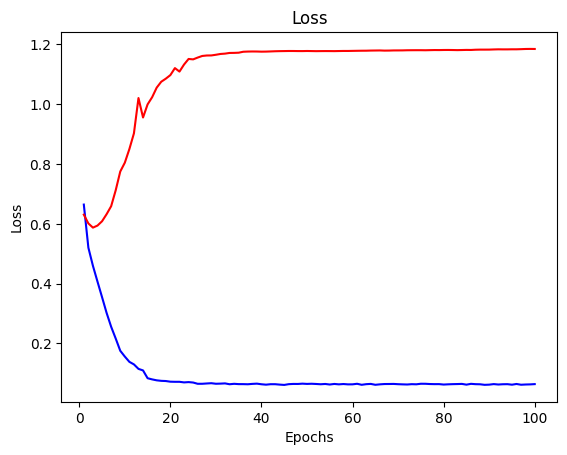

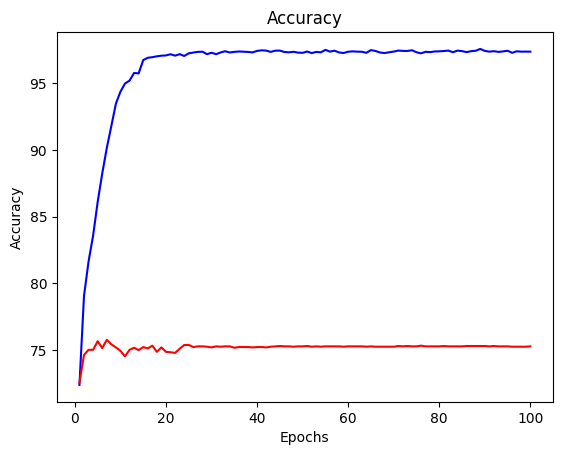

In [29]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_VGG16_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


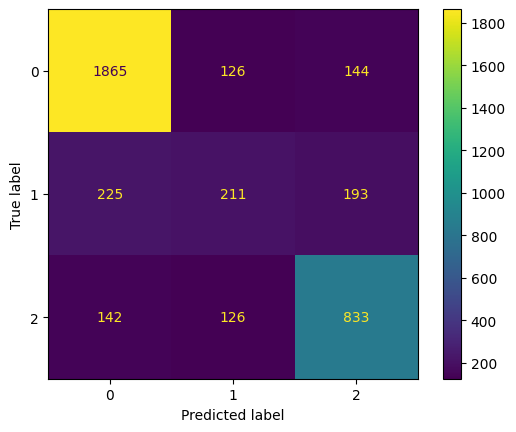

In [30]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_VGG16_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_pretrained

In [31]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [32]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [33]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [34]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.6949 - accuracy: 70.95% - val_loss: 0.6682 - val_accuracy: 71.13% - time: 38.94s
Epoch 2/100 - loss: 0.5206 - accuracy: 79.19% - val_loss: 0.6322 - val_accuracy: 73.09% - time: 39.06s
Epoch 3/100 - loss: 0.4582 - accuracy: 82.09% - val_loss: 0.6202 - val_accuracy: 74.26% - time: 38.89s
Epoch 4/100 - loss: 0.4063 - accuracy: 84.00% - val_loss: 0.6231 - val_accuracy: 74.39% - time: 39.01s
Epoch 5/100 - loss: 0.3574 - accuracy: 86.45% - val_loss: 0.6342 - val_accuracy: 74.39% - time: 39.18s
Epoch 6/100 - loss: 0.3103 - accuracy: 88.53% - val_loss: 0.6513 - val_accuracy: 74.77% - time: 38.99s
Epoch 7/100 - loss: 0.2629 - accuracy: 90.62% - val_loss: 0.6719 - val_accuracy: 74.41% - time: 38.93s
Epoch 8/100 - loss: 0.2252 - accuracy: 92.34% - val_loss: 0.7002 - val_accuracy: 74.39% - time: 38.91s
Epoch 9/100 - loss: 0.1866 - accuracy: 94.01% - val_loss: 0.7428 - val_accuracy: 74.02% - time: 38.84s
Epoch 10/100 - loss: 0.1590 - accuracy: 95.19% - val_loss: 0.7759 - val_a

Epoch 80/100 - loss: 0.0603 - accuracy: 98.18% - val_loss: 0.9359 - val_accuracy: 73.09% - time: 39.09s
Epoch 81/100 - loss: 0.0598 - accuracy: 98.12% - val_loss: 0.9332 - val_accuracy: 73.01% - time: 39.09s
Epoch 82/100 - loss: 0.0604 - accuracy: 98.11% - val_loss: 0.9385 - val_accuracy: 73.32% - time: 39.02s
Epoch 83/100 - loss: 0.0599 - accuracy: 98.10% - val_loss: 0.9424 - val_accuracy: 72.83% - time: 38.87s
Epoch 84/100 - loss: 0.0603 - accuracy: 98.12% - val_loss: 0.9462 - val_accuracy: 72.73% - time: 38.82s
Epoch 85/100 - loss: 0.0604 - accuracy: 98.15% - val_loss: 0.9354 - val_accuracy: 73.43% - time: 38.99s
Epoch 86/100 - loss: 0.0602 - accuracy: 98.11% - val_loss: 0.9392 - val_accuracy: 73.32% - time: 39.09s
Epoch 87/100 - loss: 0.0622 - accuracy: 97.99% - val_loss: 0.9518 - val_accuracy: 72.55% - time: 39.02s
Epoch 88/100 - loss: 0.0603 - accuracy: 98.15% - val_loss: 0.9381 - val_accuracy: 73.38% - time: 38.88s
Epoch 89/100 - loss: 0.0611 - accuracy: 98.13% - val_loss: 0.934

In [35]:
print(task + '_ResNet18_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet18_pretrained Performance:
Accuracy : 75.32%
F1-Score : 73.66%
Damage_Severity_Classification_ResNet18_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2135
           1       0.43      0.36      0.39       629
           2       0.70      0.71      0.71      1101

    accuracy                           0.73      3865
   macro avg       0.65      0.64      0.64      3865
weighted avg       0.72      0.73      0.73      3865



## Visualize Results & Confusion Matrix

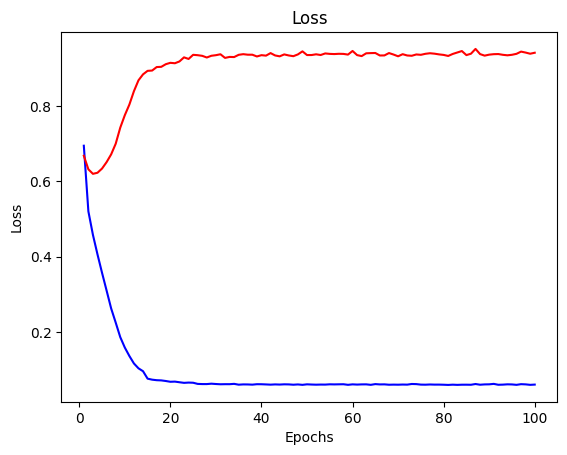

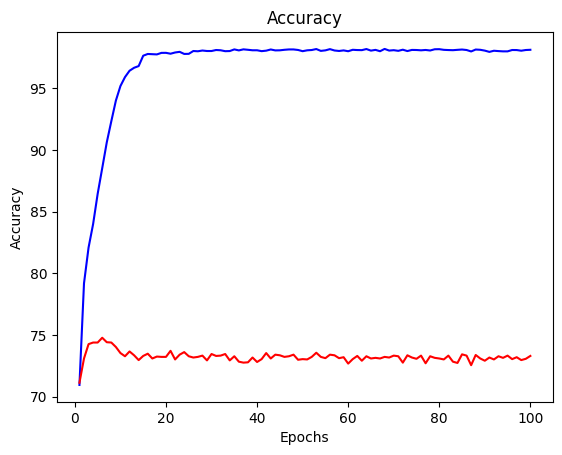

In [36]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet18_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


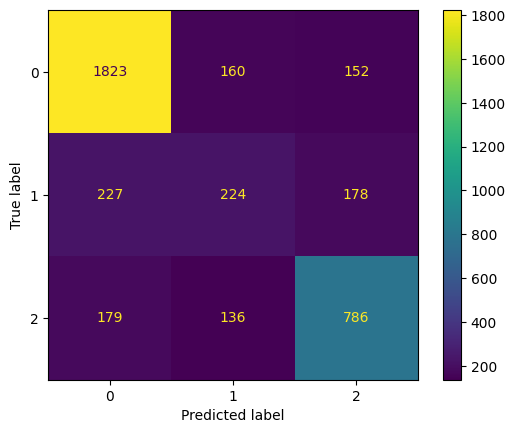

In [37]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet18_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_pretrained

In [38]:
model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/u9562361/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

## Train

In [39]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [40]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [41]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.6118 - accuracy: 75.31% - val_loss: 0.5991 - val_accuracy: 74.98% - time: 150.45s
Epoch 2/100 - loss: 0.4023 - accuracy: 84.19% - val_loss: 0.6003 - val_accuracy: 75.29% - time: 150.46s
Epoch 3/100 - loss: 0.2677 - accuracy: 90.11% - val_loss: 0.6696 - val_accuracy: 74.15% - time: 150.38s
Epoch 4/100 - loss: 0.1775 - accuracy: 94.21% - val_loss: 0.7457 - val_accuracy: 74.41% - time: 150.36s
Epoch 5/100 - loss: 0.1322 - accuracy: 95.86% - val_loss: 0.7972 - val_accuracy: 74.00% - time: 150.46s
Epoch 6/100 - loss: 0.1049 - accuracy: 96.62% - val_loss: 0.8643 - val_accuracy: 73.25% - time: 150.39s
Epoch 7/100 - loss: 0.0910 - accuracy: 96.96% - val_loss: 0.8607 - val_accuracy: 73.87% - time: 150.30s
Epoch 8/100 - loss: 0.0805 - accuracy: 97.12% - val_loss: 0.8875 - val_accuracy: 73.76% - time: 150.36s
Epoch 9/100 - loss: 0.0725 - accuracy: 97.34% - val_loss: 0.9141 - val_accuracy: 73.97% - time: 150.34s
Epoch 10/100 - loss: 0.0684 - accuracy: 97.44% - val_loss: 0.905

Epoch 80/100 - loss: 0.0256 - accuracy: 98.95% - val_loss: 0.9988 - val_accuracy: 73.82% - time: 150.13s
Epoch 81/100 - loss: 0.0254 - accuracy: 98.89% - val_loss: 1.0058 - val_accuracy: 73.71% - time: 150.05s
Epoch 82/100 - loss: 0.0256 - accuracy: 98.89% - val_loss: 1.0111 - val_accuracy: 73.74% - time: 150.21s
Epoch 83/100 - loss: 0.0260 - accuracy: 98.88% - val_loss: 0.9960 - val_accuracy: 74.15% - time: 149.99s
Epoch 84/100 - loss: 0.0251 - accuracy: 98.90% - val_loss: 1.0140 - val_accuracy: 73.66% - time: 150.04s
Epoch 85/100 - loss: 0.0257 - accuracy: 98.90% - val_loss: 1.0006 - val_accuracy: 73.64% - time: 149.74s
Epoch 86/100 - loss: 0.0259 - accuracy: 98.86% - val_loss: 1.0065 - val_accuracy: 73.82% - time: 150.06s
Epoch 87/100 - loss: 0.0260 - accuracy: 98.81% - val_loss: 1.0131 - val_accuracy: 73.58% - time: 149.95s
Epoch 88/100 - loss: 0.0257 - accuracy: 98.87% - val_loss: 0.9917 - val_accuracy: 74.13% - time: 149.97s
Epoch 89/100 - loss: 0.0259 - accuracy: 98.89% - val_lo

In [42]:
print(task + '_ResNet101_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet101_pretrained Performance:
Accuracy : 75.93%
F1-Score : 74.43%
Damage_Severity_Classification_ResNet101_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2135
           1       0.42      0.41      0.41       629
           2       0.75      0.69      0.72      1101

    accuracy                           0.74      3865
   macro avg       0.66      0.65      0.66      3865
weighted avg       0.74      0.74      0.74      3865



## Visualize Results & Confusion Matrix

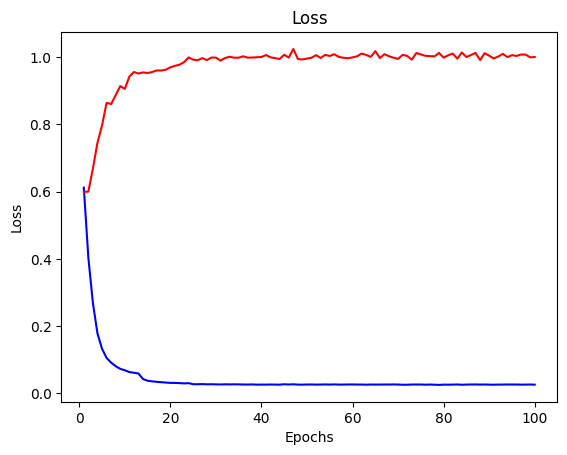

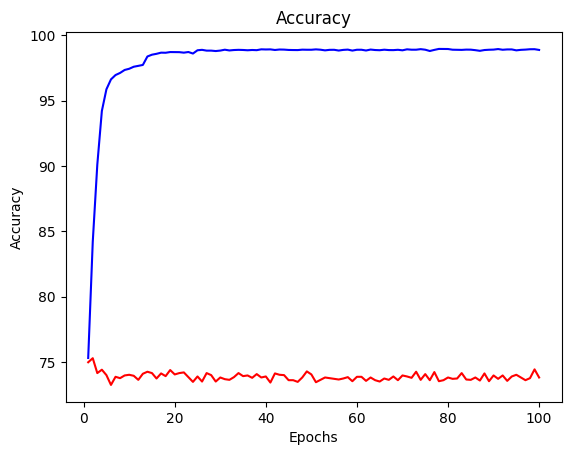

In [43]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet101_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


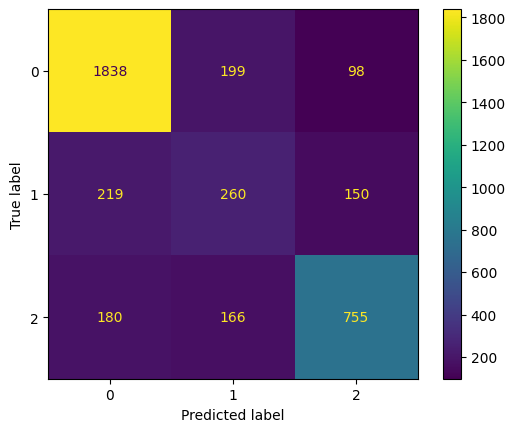

In [44]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet101_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_pretrained

In [45]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [46]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [47]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [48]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 0.7369 - accuracy: 68.60% - val_loss: 0.6876 - val_accuracy: 70.27% - time: 106.40s
Epoch 2/100 - loss: 0.5447 - accuracy: 78.36% - val_loss: 0.6301 - val_accuracy: 73.14% - time: 106.09s
Epoch 3/100 - loss: 0.4786 - accuracy: 80.99% - val_loss: 0.6114 - val_accuracy: 74.28% - time: 106.05s
Epoch 4/100 - loss: 0.4313 - accuracy: 83.17% - val_loss: 0.6019 - val_accuracy: 74.77% - time: 105.77s
Epoch 5/100 - loss: 0.3871 - accuracy: 85.13% - val_loss: 0.6016 - val_accuracy: 74.93% - time: 105.99s
Epoch 6/100 - loss: 0.3417 - accuracy: 87.10% - val_loss: 0.6122 - val_accuracy: 74.95% - time: 105.75s
Epoch 7/100 - loss: 0.2999 - accuracy: 89.09% - val_loss: 0.6318 - val_accuracy: 74.15% - time: 106.06s
Epoch 8/100 - loss: 0.2578 - accuracy: 90.95% - val_loss: 0.6593 - val_accuracy: 73.74% - time: 106.06s
Epoch 9/100 - loss: 0.2197 - accuracy: 92.71% - val_loss: 0.6952 - val_accuracy: 73.07% - time: 106.21s
Epoch 10/100 - loss: 0.1866 - accuracy: 94.20% - val_loss: 0.739

Epoch 80/100 - loss: 0.0573 - accuracy: 98.36% - val_loss: 0.9886 - val_accuracy: 71.80% - time: 106.02s
Epoch 81/100 - loss: 0.0572 - accuracy: 98.45% - val_loss: 0.9747 - val_accuracy: 72.03% - time: 105.98s
Epoch 82/100 - loss: 0.0589 - accuracy: 98.30% - val_loss: 0.9863 - val_accuracy: 71.49% - time: 106.22s
Epoch 83/100 - loss: 0.0594 - accuracy: 98.32% - val_loss: 0.9906 - val_accuracy: 71.49% - time: 106.31s
Epoch 84/100 - loss: 0.0582 - accuracy: 98.40% - val_loss: 0.9774 - val_accuracy: 71.72% - time: 106.30s
Epoch 85/100 - loss: 0.0573 - accuracy: 98.34% - val_loss: 0.9880 - val_accuracy: 71.80% - time: 105.95s
Epoch 86/100 - loss: 0.0582 - accuracy: 98.31% - val_loss: 0.9734 - val_accuracy: 71.72% - time: 105.79s
Epoch 87/100 - loss: 0.0565 - accuracy: 98.46% - val_loss: 0.9750 - val_accuracy: 71.98% - time: 106.02s
Epoch 88/100 - loss: 0.0564 - accuracy: 98.45% - val_loss: 0.9750 - val_accuracy: 71.77% - time: 105.89s
Epoch 89/100 - loss: 0.0574 - accuracy: 98.35% - val_lo

In [49]:
print(task + '_DenseNet121_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_pretrained Classification Report:')
print(cr)

Damage_Severity_Classification_DenseNet121_pretrained Performance:
Accuracy : 75.60%
F1-Score : 73.75%
Damage_Severity_Classification_DenseNet121_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2135
           1       0.38      0.40      0.39       629
           2       0.74      0.64      0.69      1101

    accuracy                           0.72      3865
   macro avg       0.64      0.63      0.64      3865
weighted avg       0.72      0.72      0.72      3865



## Visualize Results & Confusion Matrix

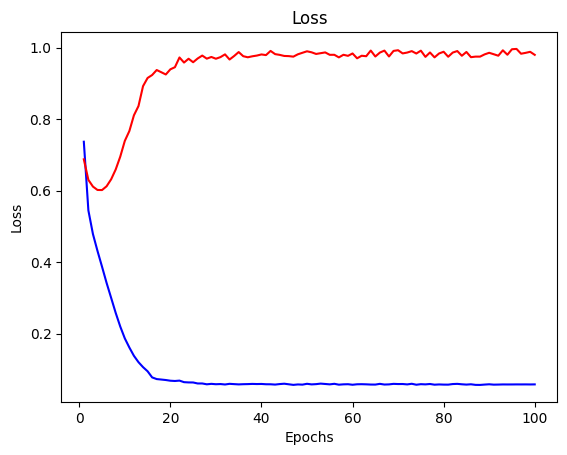

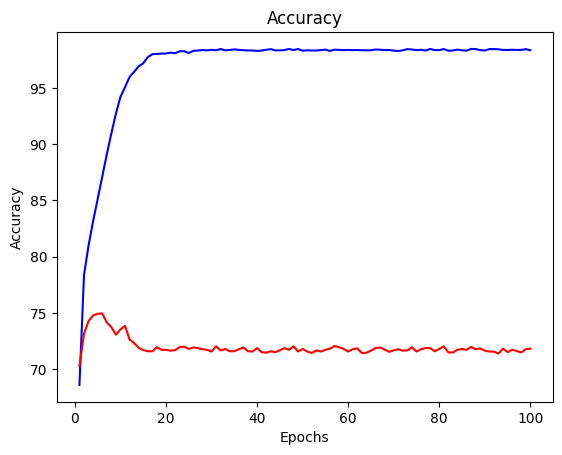

In [50]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_DenseNet121_pretrained Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


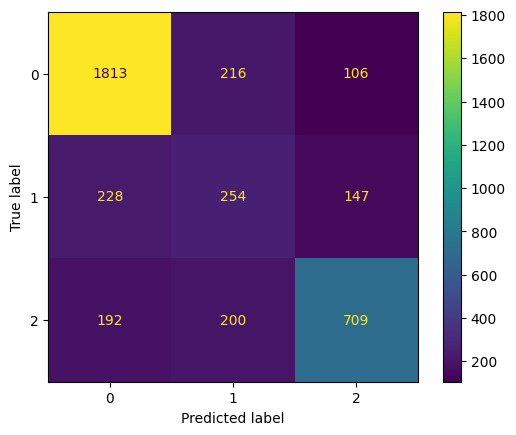

In [51]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_DenseNet121_pretrained Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()